<a href="https://colab.research.google.com/github/AdrianGuel/StochasticProcesses/blob/main/lorentzstochastic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install KDEpy
!pip install torchsde

     |████████████████████████████████| 420 kB 12.8 MB/s 
     |████████████████████████████████| 59 kB 5.5 MB/s 
     |████████████████████████████████| 38.1 MB 1.9 MB/s 
     |████████████████████████████████| 193 kB 27.6 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


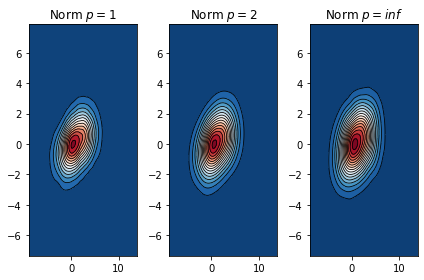

In [ ]:
from KDEpy import FFTKDE
import numpy as np
import matplotlib.pyplot as plt
# Create 2D data of shape (obs, dims)
mean = [1, 0]
cov = [[5, 1], [1, 1]]  # diagonal covariance
data = np.random.multivariate_normal(mean, cov, 10**3)

grid_points = 10**2  # Grid points in each dimension
N = 16  # Number of contours

for plt_num, norm in enumerate([1, 2, np.inf], 1):

    ax = plt.subplot(1, 3, plt_num)
    ax.set_title(f'Norm $p={norm}$')

    # Compute the kernel density estimate
    kde = FFTKDE(kernel='gaussian', norm=norm)
    grid, points = kde.fit(data).evaluate(grid_points)

    # The grid is of shape (obs, dims), points are of shape (obs, 1)
    x, y = np.unique(grid[:, 0]), np.unique(grid[:, 1])
    z = points.reshape(grid_points, grid_points).T

    # Plot the kernel density estimate
    ax.contour(x, y, z, N, linewidths=0.8, colors='k')
    ax.contourf(x, y, z, N, cmap="RdBu_r")
    #ax.plot(data[:, 0], data[:, 1], 'ok', ms=3)

plt.tight_layout()

In [ ]:
data.shape

(1000, 2)

In [ ]:
from typing import Sequence
import torchsde
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from torch import nn
from torch import optim
from torch.distributions import Normal

class StochasticLorenz(object):
    """Stochastic Lorenz attractor.
    Used for simulating ground truth and obtaining noisy data.
    Details described in Section 7.2 https://arxiv.org/pdf/2001.01328.pdf
    Default a, b from https://openreview.net/pdf?id=HkzRQhR9YX
    """
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, a: Sequence = (10., 28., 8 / 3), b: Sequence = (.1, .28, .3)):
        super(StochasticLorenz, self).__init__()
        self.a = a
        self.b = b

    def f(self, t, y):
        x1, x2, x3 = torch.split(y, split_size_or_sections=(1, 1, 1), dim=1)
        a1, a2, a3 = self.a

        f1 = a1 * (x2 - x1)
        f2 = a2 * x1 - x2 - x1 * x3
        f3 = x1 * x2 - a3 * x3
        return torch.cat([f1, f2, f3], dim=1)

    def g(self, t, y):
        x1, x2, x3 = torch.split(y, split_size_or_sections=(1, 1, 1), dim=1)
        b1, b2, b3 = self.b

        g1 = x1 * b1
        g2 = x2 * b2
        g3 = x3 * b3
        return torch.cat([g1, g2, g3], dim=1)

    @torch.no_grad()
    def sample(self, x0, ts, noise_std, normalize):
        """Sample data for training. Store data normalization constants if necessary."""
        xs = torchsde.sdeint(self, x0, ts, method='srk',adaptive=True)
        if normalize:
            mean, std = torch.mean(xs, dim=(0, 1)), torch.std(xs, dim=(0, 1))
            xs.sub_(mean).div_(std).add_(torch.randn_like(xs) * noise_std)
        return xs

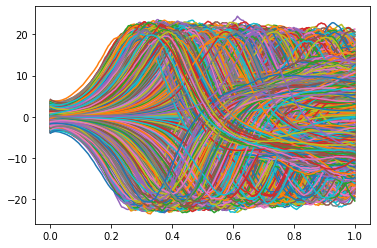

In [ ]:
batch_size, state_size, t_size = 10**5, 3, 10**3
tf, noise_std=1,0.1
y0 = torch.randn(batch_size, state_size, device='cuda')
ts = torch.linspace(0, tf, t_size, device='cuda')
xs = StochasticLorenz().sample(y0, ts, noise_std, normalize=False)
x1=xs[:,:,0]
x2=xs[:,:,1]
x3=xs[:,:,2]
plt.plot(ts.cpu().detach().numpy(),x1.cpu().detach().numpy())
plt.show()

In [ ]:
y0.shape

torch.Size([1000, 3])